In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow import keras

def one_hot_encode(df, col='seq', seq_len=44):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        lst = [nuc_d[x] for x in seq]
        if seq_len>len(seq):
            lst += [nuc_d['n']]*(seq_len-len(seq))
        a = np.array(lst)
        vectors[i] = a
    return vectors

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2


datadir=f"/Users/john/data"
name,seq_len="pl3-1-2",118
original_seq = 'atcccgggtgaggcatcccaccatcctcagtcacagagagacccaatctaccatcagcatcagccagtaaagattaagaaaaacttagggtgaaagaaatttcacctaacacggcgca'
original_seq=original_seq.upper()
prefix,suffix = original_seq[:72],original_seq[96:]
model = keras.models.load_model(f"{datadir}/models/pl3-1-2.keras")
df = pd.read_csv(f"{datadir}/Promter/results/{name}/{name}_final.csv")
scaler = preprocessing.StandardScaler()
scaler.fit_transform(df.loc[:,"score"].values.reshape(-1,1))
df["isCore"] = df["seq"].apply(lambda x: x.startswith(prefix) and x.endswith(suffix))
df["core"] =df.seq.apply(lambda x:x[72:96])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


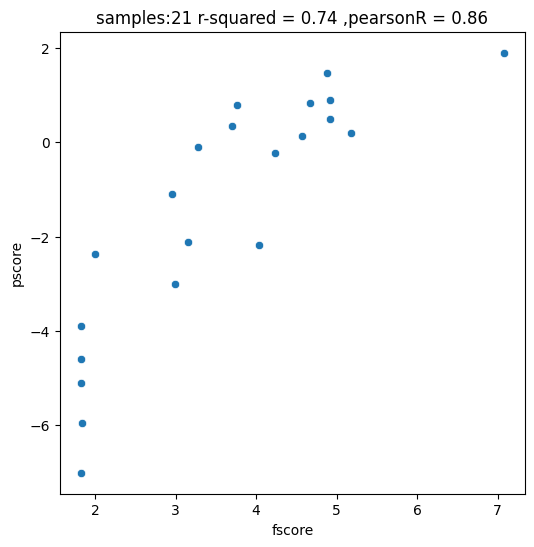

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fdf = pd.read_csv(f"{datadir}/Promter/results/fscore5d.csv",names=["index","seq","length", "distance","fscore"],sep="\t")
fdf["seq"]= fdf.seq.apply(lambda x:prefix+x+suffix)
fdf.loc[20]=[21,original_seq,24,0,1181]
onehot_data = one_hot_encode(fdf,seq_len=seq_len)
scores = model.predict(onehot_data)
fdf["pscore"]= scaler.inverse_transform(scores)
fdf["fscore"] = np.log(fdf["fscore"])
sdf=fdf
num=len(sdf)
values = np.vstack([sdf['fscore'],sdf["pscore"]])
kernel = stats.gaussian_kde(values)(values)
fig, ax = plt.subplots(figsize=(6, 6))
r = r2(sdf["pscore"],sdf["fscore"])
pr =  stats.pearsonr(sdf["fscore"],sdf["pscore"])
plt.title(f"samples:{num} r-squared = {r:.2f} ,pearsonR = {pr[0]:.2f}")
splot=sns.scatterplot(data=sdf,x="fscore", y="pscore")

In [10]:
import pandas as pd
import numpy as np
data_dir="/Users/john/data"
ddf = pd.read_csv(f"{data_dir}/Promter/DNA1_clean.csv")
hits =set(fdf.seq.values) 
ddf=ddf[ddf.seq.isin(hits)]
name=f"pl3-1-2"
rna_df = pd.read_csv(f"{data_dir}/Promter/results/{name}/{name}.csv")
hitb =set(ddf.barcode.values) 
rna_df.rename(columns={"rna_seq":"seq"},inplace=True)
rna_df = rna_df[rna_df.barcode.isin(hitb)]
rna_df["length"] = rna_df["seq"].apply(len)
rna_df = rna_df[(rna_df["length"]<=38)&(rna_df["length"]>=34)]
barcode_df = rna_df.groupby("barcode")["rna_counts"].sum().reset_index()
rdf = ddf.merge(barcode_df,how="left")
rdf = rdf.fillna(0)

tdf = rdf.groupby("seq")[["plasmid_counts","rna_counts"]].sum().reset_index()
tdf=tdf[tdf["rna_counts"]!=0.0]
tdf["score"] = np.log(tdf["rna_counts"]/tdf["plasmid_counts"])
ptdf=tdf.merge(fdf,on="seq")

cdf=rdf[rdf["rna_counts"]!=0.0]
cdf = cdf.groupby("seq")[["plasmid_counts","rna_counts"]].sum().reset_index()
cdf["score"] = np.log(cdf["rna_counts"]/cdf["plasmid_counts"])
pcdf=cdf.merge(fdf,on="seq")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/john/data/Promter/results/pl3-1-2/pl3-1-2.csv'

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=sdf,x="fscore", y="pscore",label="Model",ax=ax)
sns.lineplot(data=pcdf,x="fscore", y="score",label="Raw",ax=ax,)
sns.lineplot(data=ptdf,x="fscore", y="score",label="Current",ax=ax)
# sns.scatterplot(data=sdf,x="fscore", y="pscore",label="Model",ax=ax)
# sns.scatterplot(data=cdf,x="fscore", y="pscore",label="Raw",ax=ax)
# sns.scatterplot(data=tdf,x="fscore", y="score",label="Current",ax=ax)
plt.legend()
plt.show()